In [2]:
import numpy as np
import seaborn as sns
import math
import pandas as pd
import sqlite3
import csv
import re
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import statsmodels.api as sm
import statsmodels.tools
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures, normalize
import random

In [3]:
conn = sqlite3.connect("data/cities_infections_density.db")
c = conn.cursor()
c.execute('PRAGMA foreign_keys = ON')

/home/desmond/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in log

/home/desmond/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in log



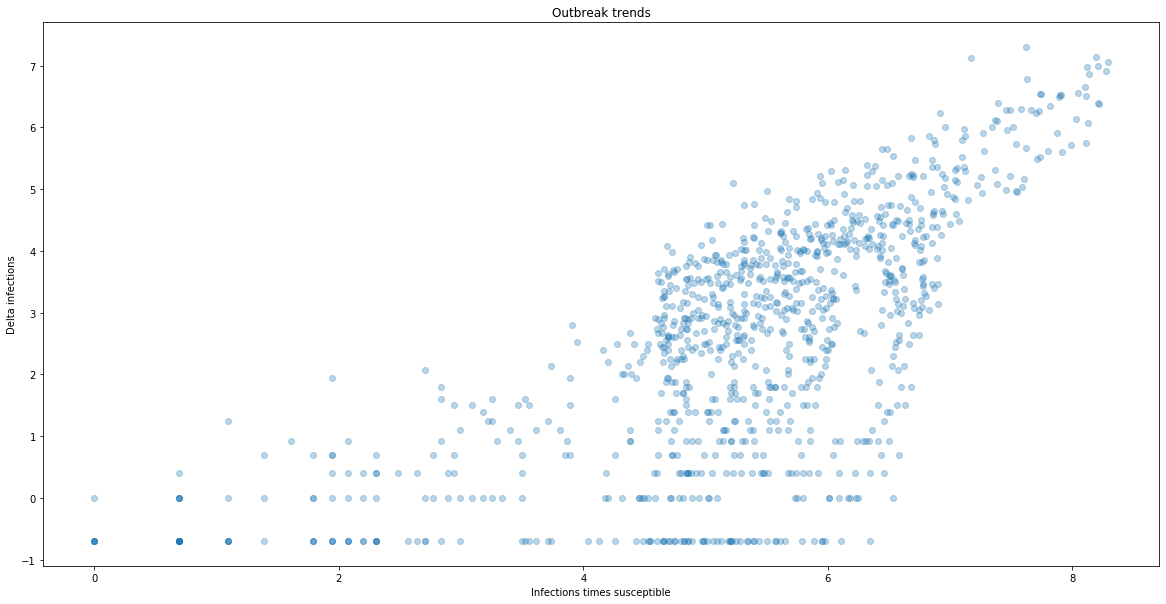

In [4]:
plt.figure(figsize=(20, 10))
plt.title("Outbreak trends")
plt.xlabel("Infections times susceptible")
plt.ylabel("Delta infections")

locations = []

c.execute('SELECT DISTINCT location FROM cities;')
for row in c:
    locations.append(row[0])

X = []
Y = []
for location in locations:

    start = False
    counter = 0
    
    c.execute('SELECT delta_infected, susceptible, infected FROM cities WHERE location="'+location+'" ORDER BY DATE ASC;')
    for entry in c:
        include = True
        delta_infected = entry[0]
        susceptible = entry[1]
        infected = entry[2]
        if infected > 4000:
            #print(location)
            include = False
        if infected > 100:
            start = True
        if start != True or include == False:
            continue
        X.append(infected)
        counter += 1
        Y.append(delta_infected)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])

        
    # Plot and show
    #if include == True:
        #plt.scatter(X, Y, label=location)
with np.errstate(divide='ignore'):
    Y = np.array(Y)
    Y = np.log(Y)
    X = np.array(X)
    X = np.log(X)
plt.scatter(X, Y, alpha=0.3)
#plt.legend()
plt.show()

conn.commit()

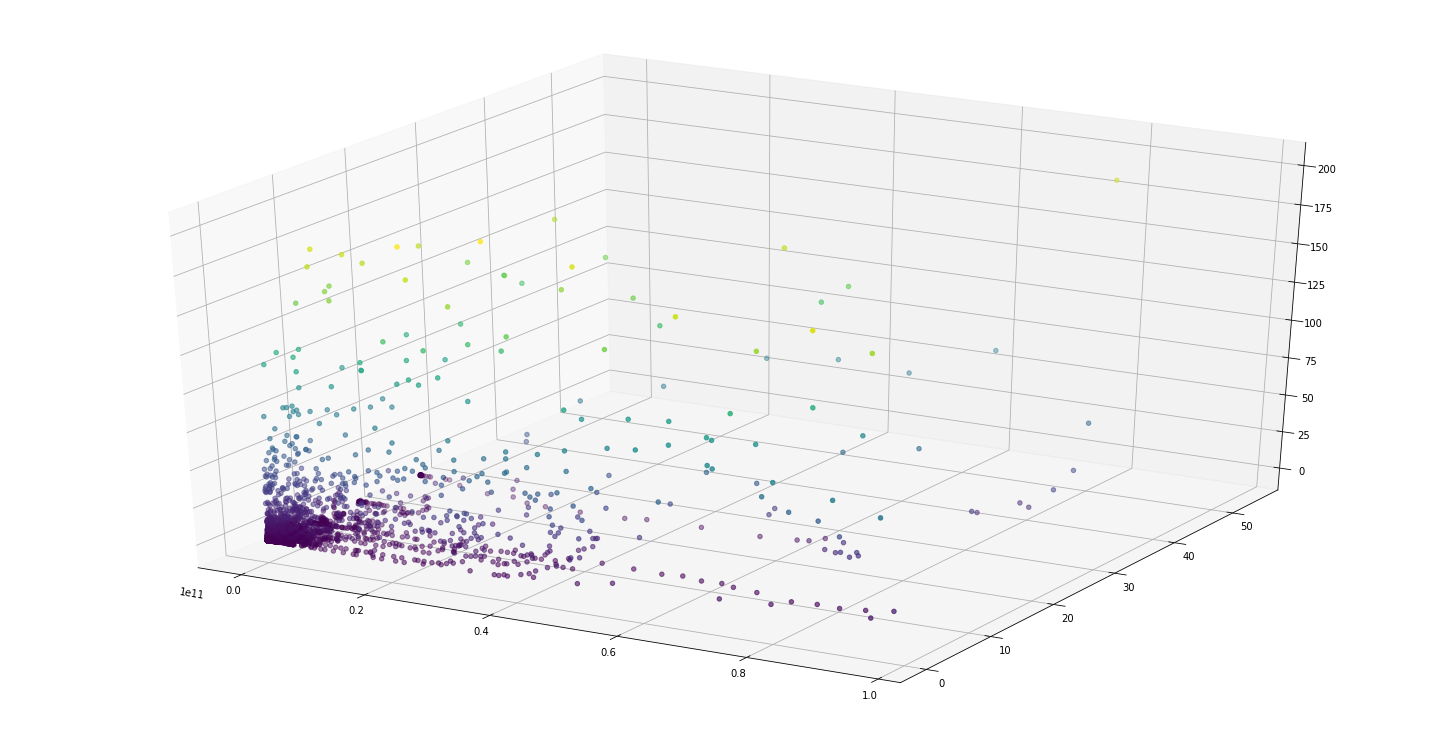

In [5]:
'''
plt.figure(figsize=(20, 10))
plt.title("Outbreak trends")
plt.xlabel("Infections times susceptible")
plt.ylabel("Delta infections")
'''
locations = []

fig = plt.figure(figsize=(20, 10))
ax = Axes3D(fig)

c.execute('SELECT DISTINCT location FROM cities;')
for row in c:
    locations.append(row[0])

X = []
Y = []
Z = []
for location in locations:

    start = False
    counter = 0
    
    c.execute('SELECT delta_infected, susceptible, infected, deaths FROM cities WHERE location="'+location+'" ORDER BY DATE ASC;')
    for entry in c:
        include = True
        delta_infected = entry[0]
        susceptible = entry[1]
        infected = entry[2]
        deaths = entry[3]
        if infected*susceptible > 100000000000 or delta_infected > 200:
            #print(location)
            include = False
        if infected > 0:
            start = True
        if start != True or include == False:
            continue
        X.append(susceptible*infected)
        Z.append(delta_infected)
        counter += 1
        Y.append(deaths)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])

        
    # Plot and show
    #if include == True:
        #plt.scatter(X, Y, label=location)

#plt.scatter(X, Y, alpha=0.1)
#plt.legend()
ax.scatter(X, Y, Z, c=Z, cmap='viridis')
#ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor=label'none', alpha=0.3)
plt.show()

conn.commit()

In [364]:
X = []
Y = []

for location in locations:
    start = False
    counter = 0
    include = True
    
    c.execute('SELECT delta_infected, susceptible, infected, recovered, deaths, density FROM cities WHERE location="'+location+'" ORDER BY DATE ASC;')
    rows = []
    for entry in c:
        rows.append(entry)
    for i, entry in enumerate(rows):
        if i <= 1:
            continue
        if i == len(rows)-1:
            continue
        delta_infected = rows[i+1][0]
        susceptible = entry[1]
        infected = entry[2]
        recovered = entry[3]
        deaths = entry[4]
        prev_infected = rows[i-1][2]
        prev_prev_infected = rows[i-2][2]
        density = entry[5]
        #if entry[0] > 4000:
            #print(location)
            #include = False
        if infected > 0:
            start = True
        if start != True:
            continue
        X.append([counter, susceptible, infected, recovered, deaths, susceptible*infected, prev_infected, density])
        counter += 1
        Y.append(delta_infected)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])
X = sm.add_constant(X)
#print(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     3092.
Date:                Thu, 16 Apr 2020   Prob (F-statistic):               0.00
Time:                        00:52:01   Log-Likelihood:                -26298.
No. Observations:                3635   AIC:                         5.261e+04
Df Residuals:                    3626   BIC:                         5.267e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.4518     11.397     -1.356      0.175     -37.796       6.892
x1             1.2935      0.317      4.074      0.000       0.671       1.916
x2          6.956e-09   3.21e-08      0.216      0.829    -5.6e-08       7e-08
x3             0.6767      0.013     50.550      0.000       0.650       0.703
x4            -0.0105      0.002     -5.451      0.000      -0.014      -0.007
x5             0.1891      0.026      7.257      0.000       0.138       0.240
x6          2.525e-10   1.18e-11     21.342      0.000    2.29e-10    2.76e-10
x7            -0.6472      0.014    -47.809      0.000      -0.674      -0.621
x8            -0.0030      0.005     -0.575      0.565      -0.013       0.007
==============================================================================
Omnibus:                     4726.832   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9946351.712
Skew:                           6.231   Prob(JB):                         0.00
Kurtosis:                     258.959   Cond. No.                     1.97e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Held-out data from  China, Tianjin
Number of data points:  3509
Number of training points:  2456
Number of validation points:  1053

Training r^2:  0.8827546091546727
Training RMSE:  315.73637716339806

Validation r^2:  0.8353956856056288
Validation RMSE:  366.0504618019712

Average y_val:  125.26068376068376
STD y_val:  902.2364158246874


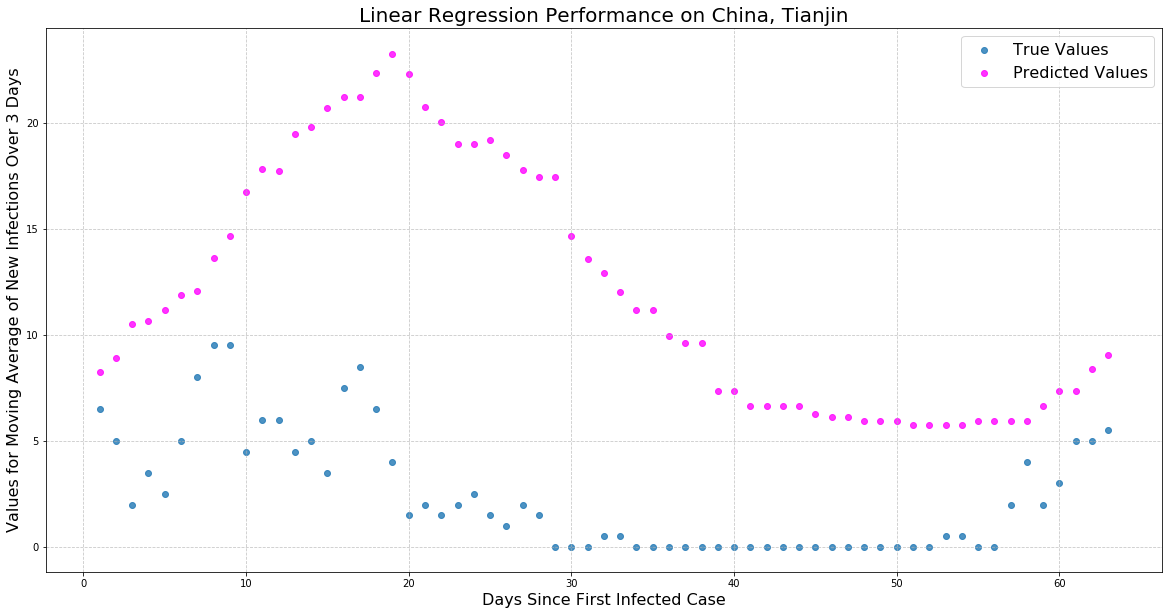

In [387]:
X = []
Y = []

test_country = random.choice(locations)
while(test_country == "China, Hubei"):
    test_country = random.choice(locations)

for location in locations:
    if location == "China, Hubei":
        continue
    if location == test_country:
        print("Held-out data from ", location)
        continue
    start = False
    counter = 1
    
    c.execute('SELECT delta_infected, susceptible, infected, recovered, deaths, density FROM cities WHERE location="'+location+'" ORDER BY DATE ASC;')
    rows = []
    for entry in c:
        rows.append(entry)
    for i, entry in enumerate(rows):
        if i <= 1:
            continue
        if i == len(rows)-1:
            continue
        include = True
        delta_infected = rows[i+1][0]
        susceptible = entry[1]
        infected = entry[2]
        recovered = entry[3]
        deaths = entry[4]
        density = entry[5]
        prev_infected = rows[i-1][2]
        population = susceptible + infected + recovered + deaths
        #if infected > 80000:
            #print(location)
            #include = False
        #if delta_infected < 50:
            #print(location)
            #include = False
        if infected > 0:
            start = True
        if start != True or include == False:
            continue
        X.append([counter, infected, deaths])
        counter += 1
        Y.append(delta_infected)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])

        
poly = PolynomialFeatures(2)
#poly.fit_transform(X)
print("Number of data points: ", len(Y))
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, Y, test_size=0.3)
print("Number of training points: ", len(y_train))
lm = sklearn.linear_model.Lasso(normalize=True)
model = lm.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

#X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_rest, y_rest, test_size=0.5)
print("Number of validation points: ", len(y_val))
#print("Number of testing points: ", len(y_test))
y_val_pred = model.predict(X_val)

print()
print("Training r^2: ", model.score(X_train, y_train))
print("Training RMSE: ", math.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_pred)))
print()
print("Validation r^2: ", model.score(X_val, y_val))
print("Validation RMSE: ", math.sqrt(sklearn.metrics.mean_squared_error(y_val_pred, y_val)))

print()
print("Average y_val: ", np.average(y_val))
print("STD y_val: ", np.std(y_val))

plt.figure(figsize=(20, 10))
plt.title("Linear Regression Performance on " + test_country, fontsize=20)
plt.xlabel("Days Since First Infected Case", fontsize=16)
plt.ylabel("Values for Moving Average of New Infections Over 3 Days", fontsize=16)

graphX = []
testX = []
graphY = []
predY = []

c.execute('SELECT delta_infected, susceptible, infected, recovered, deaths, density FROM cities WHERE location="'+test_country+'" ORDER BY DATE ASC;')
start = False
include = True
counter = 1
rows = []
for entry in c:
    rows.append(entry)
for i, entry in enumerate(rows):
    if i <= 1:
        continue
    if i == len(rows)-1:
        continue
        
    delta_infected = rows[i+1][0]
    susceptible = entry[1]
    infected = entry[2]
    recovered = entry[3]
    deaths = entry[4]
    prev_infected = rows[i-1][2]
    population = susceptible + infected + recovered + deaths
    #if delta_infected < 50:
        #print(location)
        #include = False
    if infected > 0:
        start = True
    if start != True or include == False:
        continue
    testX.append([counter, infected, deaths])
    graphX.append([counter])
    counter += 1
    graphY.append(delta_infected)
predY = model.predict(testX)

plt.grid(linestyle='--', alpha=0.7)
plt.scatter(graphX, graphY, alpha=0.8, label="True Values")
plt.scatter(graphX, predY, alpha=0.8, c="magenta", label="Predicted Values")
plt.legend(prop={"size":16})
plt.show()


In [200]:
X = []
Y = []

for location in locations:
    start = False
    counter = 1
    include = True
    
    c.execute('SELECT delta_infected, susceptible, infected, recovered, deaths FROM cities WHERE location="'+location+'" ORDER BY DATE ASC;')
    for entry in c:
        susceptible = entry[1]
        infected = entry[2]
        recovered = entry[3]
        deaths = entry[4]
        population = susceptible + infected + recovered + deaths
        #if entry[0] > 4000:
            #print(location)
            #include = False
        if entry[0] > 0:
            start = True
        if start != True:
            continue
        X.append([counter, susceptible, ])
        counter += 1
        Y.append(infected)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])

X = sm.add_constant(X)
#print(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1198.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        02:51:06   Log-Likelihood:                -36966.
No. Observations:                3789   AIC:                         7.394e+04
Df Residuals:                    3784   BIC:                         7.397e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -178.5875    140.158     -1.274      0.203    -453.380      96.205
x1            22.4568      3.679      6.105      0.000      15.245      29.669
x2          1.063e-06   3.91e-07      2.719      0.007    2.97e-07    1.83e-06
x3            -0.3676      0.019    -19.001      0.000      -0.406      -0.330
x4            11.0207      0.177     62.354      0.000      10.674      11.367
==============================================================================
Omnibus:                     5942.845   Durbin-Watson:                   0.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4100942.329
Skew:                           9.838   Prob(JB):                         0.00
Kurtosis:                     162.965   Cond. No.                     3.87e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [366]:
print(len(locations))

59
